In [1]:
#To register MainEnvRL with local copy of Gym
"""
from gym.envs.registration import register
 
register(
    id='MainEnvRL-v2',
    #entry_point='balance_bot.envs:BalancebotEnv',
    entry_point='MainEnv_RL.envs:MainEnvRL',
)

"""
#import gym
#for env in gym.envs.registry.env_specs:
#    print(env)
    
    #if 'MainEnvRL-v1' == env:
    #     print('Remove {} from registry'.format(env))
         #del gym.envs.registry.env_specs[env]
            
            
#import MainEnv_RL

#env = gym.make('MainEnvRL-v2')
#env.reset()
"""
for env in gym.envs.registry.env_specs:
     if 'MainEnvRL-v0' in env:
        print('Remove {} from registry'.format(env))
        del gym.registry.env_specs[env]
"""                


"\nfor env in gym.envs.registry.env_specs:\n     if 'MainEnvRL-v0' in env:\n        print('Remove {} from registry'.format(env))\n        del gym.registry.env_specs[env]\n"

## Train the policy

Ep: 501   Total Steps taken: 14452


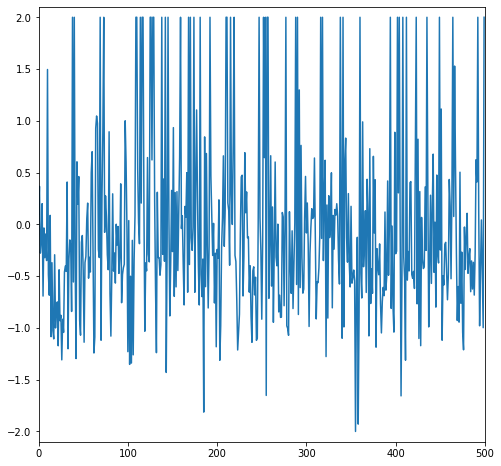

Ep: 501  tStep: 1  Reward: -0.45  Button Pressed? 0  GRU output: 0 GRU_TruePosQty 0 GRU_TrueNegQty 10378 GRU_FalsePosQty 24 GRU_FalseNegQty 50 TotalQty 10452 unfilled GRU buffer at size 1
Ep: 501  tStep: 2  Reward: -0.4  Button Pressed? 0  GRU output: 0 GRU_TruePosQty 0 GRU_TrueNegQty 10378 GRU_FalsePosQty 24 GRU_FalseNegQty 50 TotalQty 10452 unfilled GRU buffer at size 2
Ep: 501  tStep: 3  Reward: -0.35  Button Pressed? 0  GRU output: 0 GRU_TruePosQty 0 GRU_TrueNegQty 10378 GRU_FalsePosQty 24 GRU_FalseNegQty 50 TotalQty 10452 unfilled GRU buffer at size 3
Ep: 501  tStep: 4  Reward: -0.3  Button Pressed? 0  GRU output: 0 GRU_TruePosQty 0 GRU_TrueNegQty 10378 GRU_FalsePosQty 24 GRU_FalseNegQty 50 TotalQty 10452 unfilled GRU buffer at size 4
Ep: 501  tStep: 5  Reward: -0.3  Button Pressed? 0  GRU output: 0 GRU_TruePosQty 0 GRU_TrueNegQty 10378 GRU_FalsePosQty 24 GRU_FalseNegQty 50 TotalQty 10452 unfilled GRU buffer at size 5
Ep: 501  tStep: 6  Reward: -0.31  Button Pressed? 0  GRU output

NameError: name 'model' is not defined

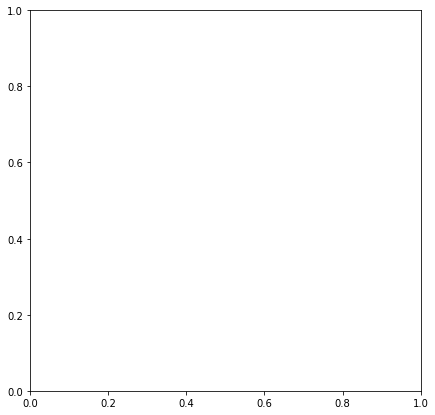

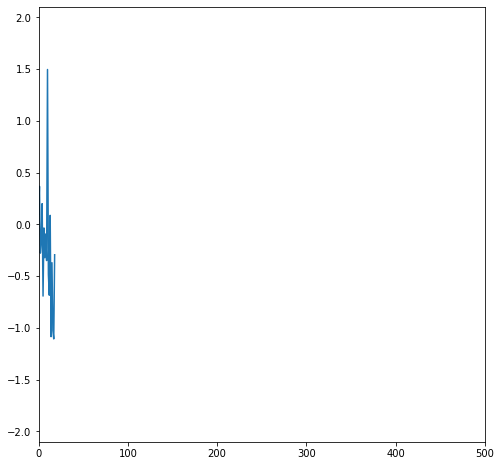

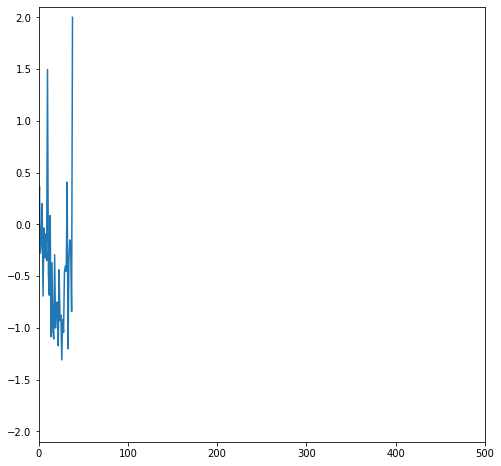

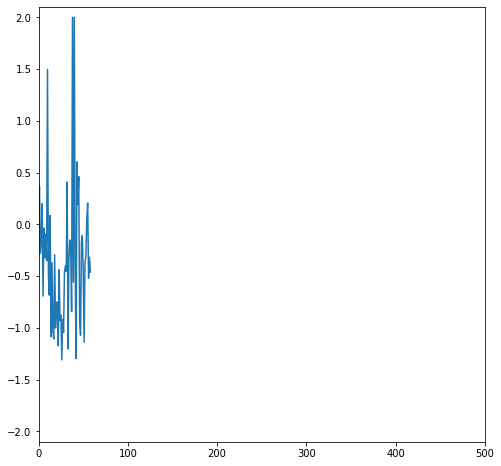

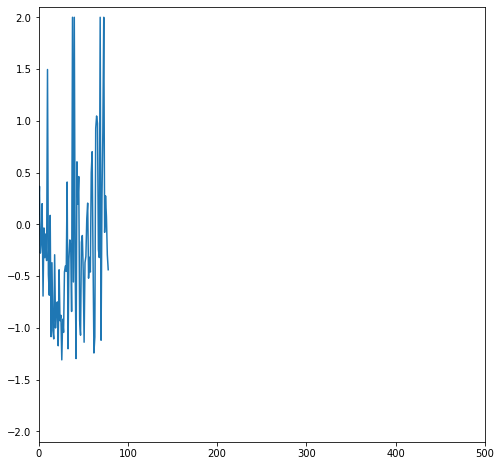

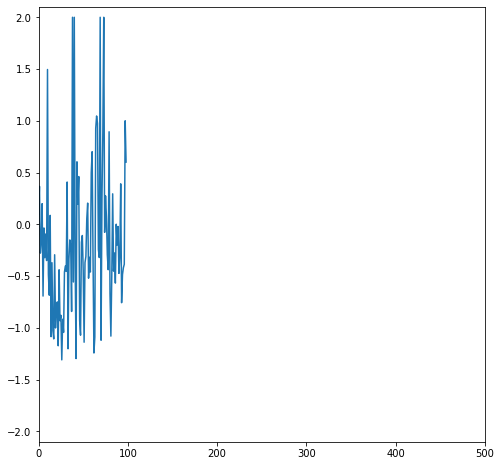

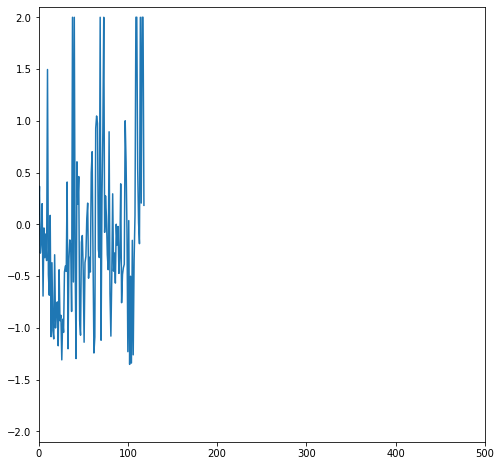

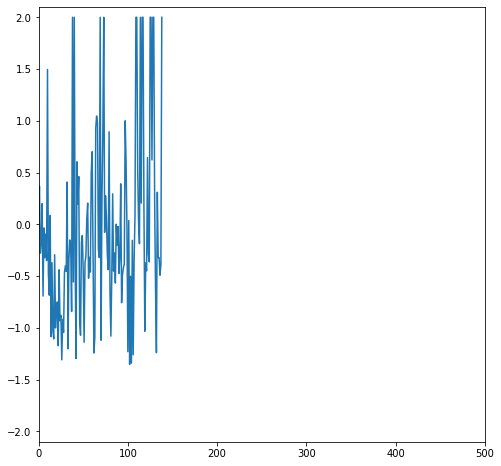

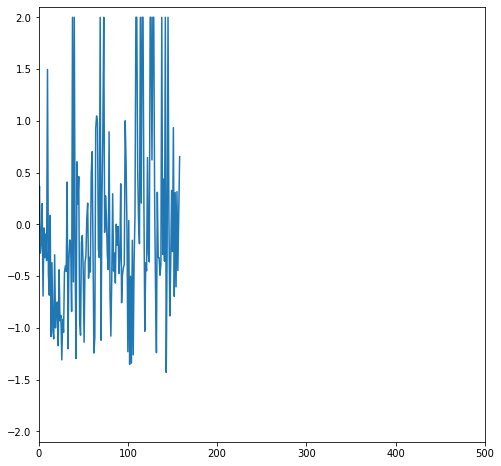

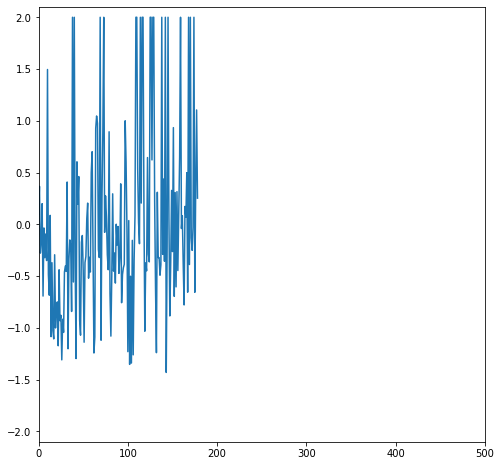

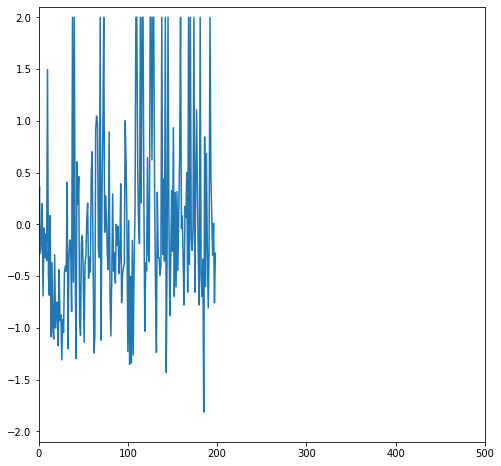

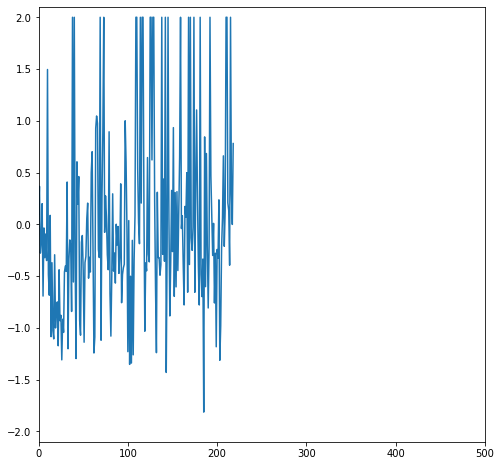

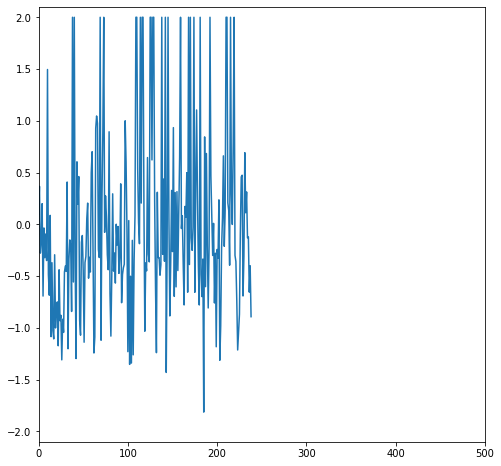

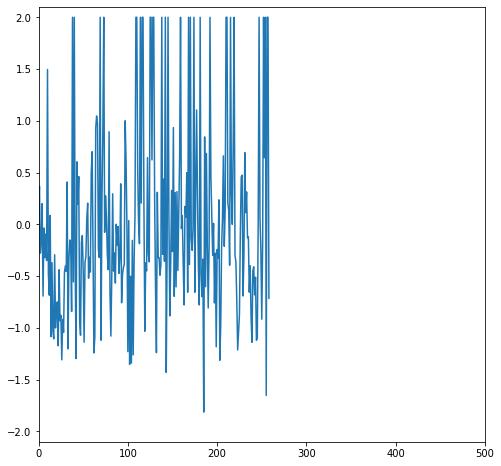

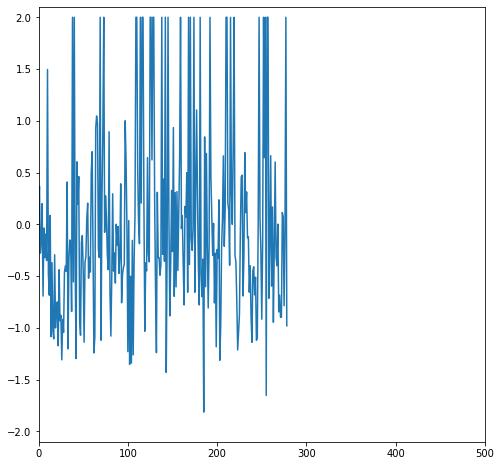

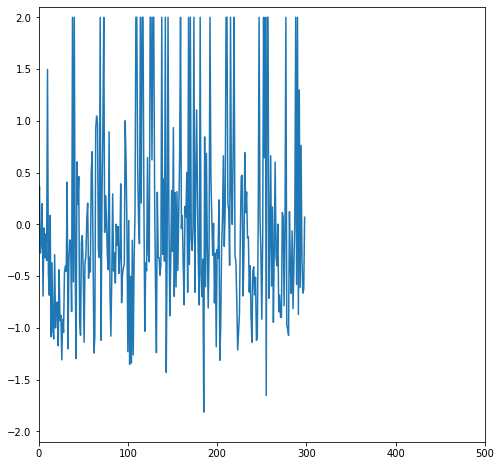

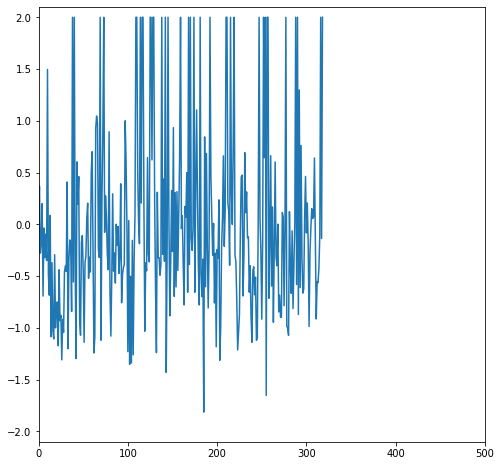

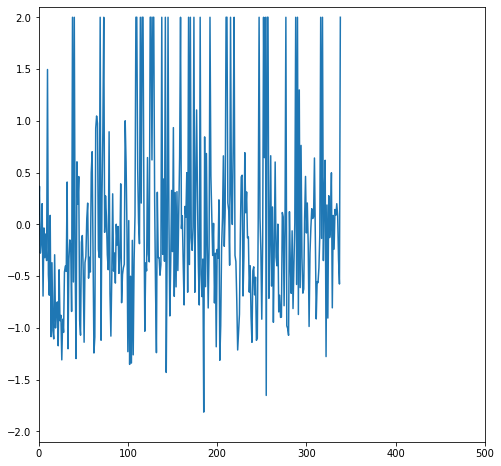

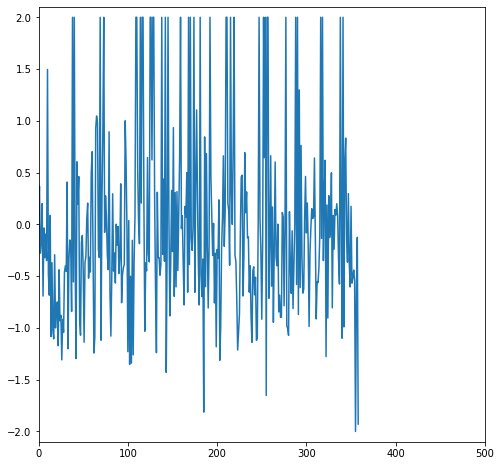

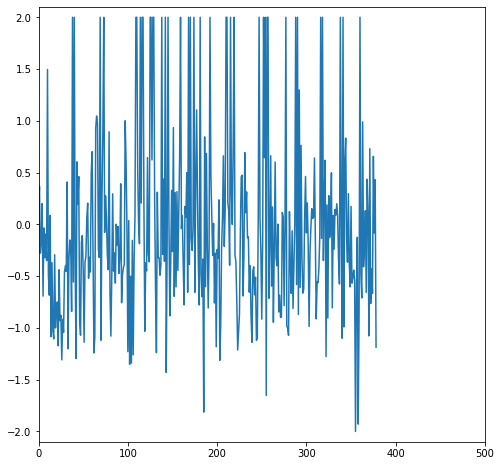

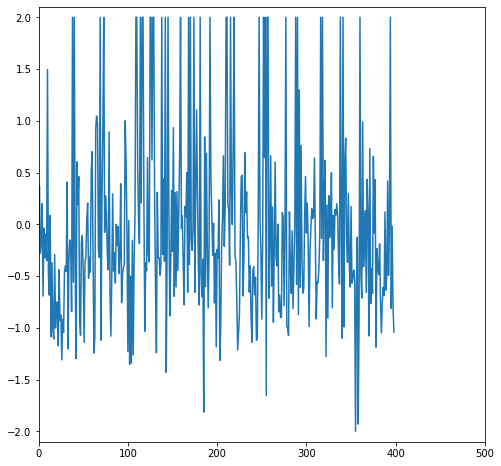

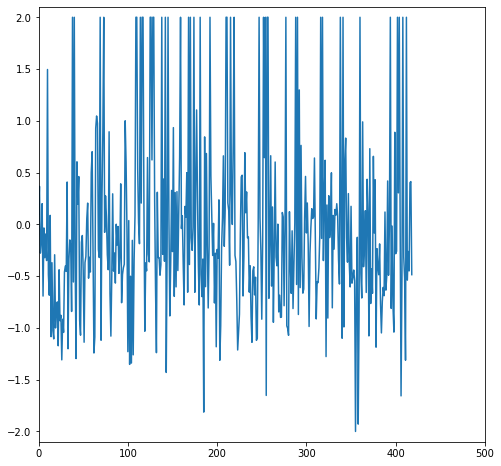

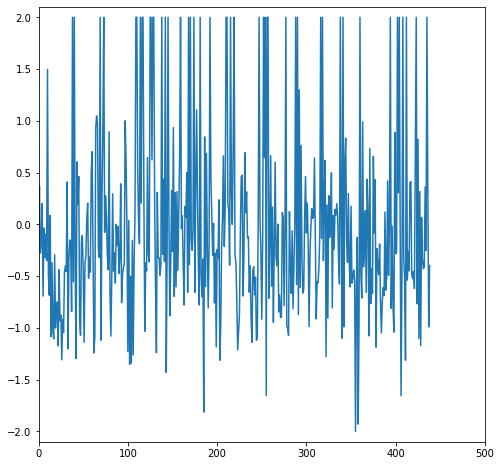

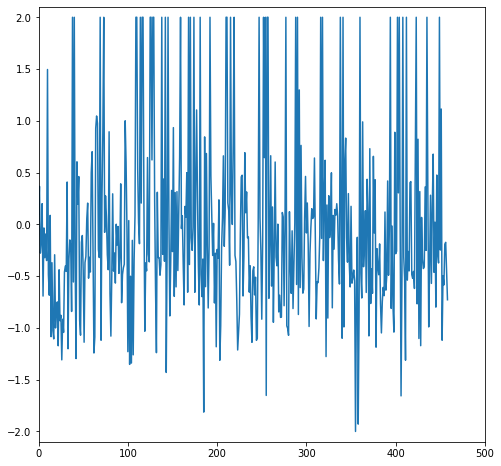

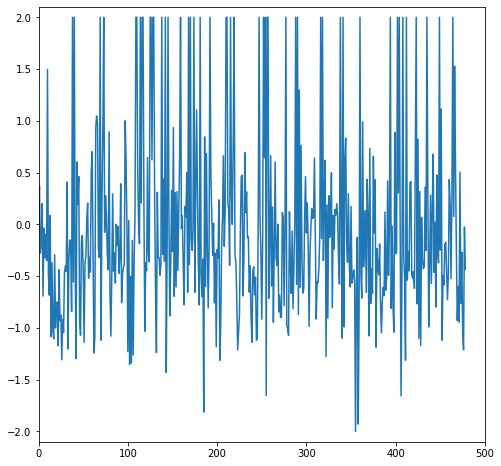

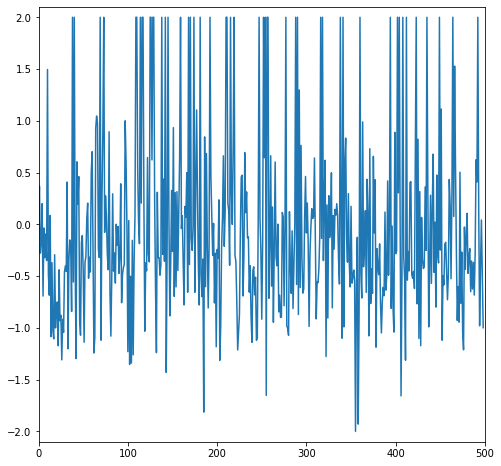

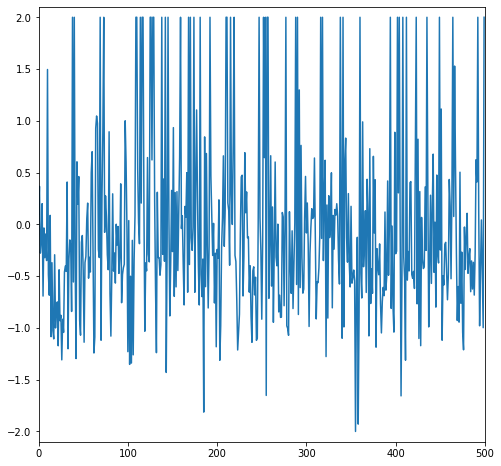

In [1]:
#https://github.com/ZhizhenQin/BalancingBot/blob/master/balance-bot/balance_bot/balancebot_task.py


#%load_ext tensorboard

import warnings
warnings.filterwarnings('ignore',category=FutureWarning)
import tensorflow as tf
from tensorflow.keras.utils import to_categorical

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
import torch.optim as optim

import gym
from stable_baselines import DQN, PPO2
from stable_baselines import results_plotter
from stable_baselines.bench import Monitor
from stable_baselines.results_plotter import load_results, ts2xy
from stable_baselines.common.noise import AdaptiveParamNoiseSpec
from stable_baselines.common.callbacks import BaseCallback
from stable_baselines.deepq.policies import MlpPolicy
from stable_baselines.common.policies import FeedForwardPolicy, register_policy,LstmPolicy
from stable_baselines.common.tf_layers import conv, linear, conv_to_fc, lstm
from stable_baselines.common.vec_env import DummyVecEnv
from stable_baselines.common.env_checker import check_env
from datetime import date
import csv
#import balance_bot
import socket
import numpy as np
from time import sleep
import UR5_RL

class GRUNet(nn.Module):
        def __init__(self, input_dim, hidden_dim, output_dim, n_layers, drop_prob=0.2):
            super(GRUNet, self).__init__()
            self.hidden_dim = hidden_dim
            self.n_layers = n_layers

            self.gru = nn.GRU(input_dim, hidden_dim, n_layers, batch_first=True, dropout=drop_prob)
            self.fc = nn.Linear(hidden_dim, output_dim)
            self.relu = nn.ReLU()

        def forward(self, x, h):
            out, h = self.gru(x, h)
            out = self.fc(self.relu(out[:,-1]))
            return out, h

        def init_hidden(self, batch_size):
            weight = next(self.parameters()).data
            hidden = weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device)
            return hidden

device = torch.device("cpu")

#HOST_SnS = '192.168.0.103'
HOST_SnS = '128.138.224.89'
PORT_SnS= 65490


try:
    # Create a TCP/IP socket
    sock_SnS = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
    #sock_SnS.setblocking(False)
    # Connect the socket to the port where the server is listening
    server_address_SnS = (HOST_SnS, PORT_SnS)
    print('connecting to {} port {}'.format(*server_address_SnS))
    sock_SnS.connect(server_address_SnS)


    #def callback(lcl, glb):
         #stop training if reward exceeds 199
    #    is_solved = lcl['t'] > 1000 and sum(lcl['episode_rewards'][-101:-1]) / 100 >= 1
    #    return is_solved

    #https://stable-baselines.readthedocs.io/en/master/guide/custom_policy.html
    #Layers of 20 and 15

    #Do this only after restarting the notebook!! 
    #register_policy('ScottLSTMPolicy', ScottLSTMPolicy)    
    #print("lstm registered")

    #try:
    
    #code stopped at ep 36 at 10steps per ep, 80 ep
    StepsPerEpisode=30 #was 10
    TotalEpisodes=500  #was 80
    env= gym.make("ur5-rl-v0",StepsPerEpisode=StepsPerEpisode,TotalEpisodes=TotalEpisodes,
                 continuousactionspace=False,actualbutton=True,GRUrewards=False)
    env = DummyVecEnv([lambda: env])

    timesteps=(StepsPerEpisode*TotalEpisodes)
    print("Total timesteps:",timesteps)
    
    
    class ScottLSTMPolicy(LstmPolicy):
        def __init__(self, sess, ob_space, ac_space, n_env=1, n_steps=StepsPerEpisode,
                     n_batch=StepsPerEpisode, n_lstm=StepsPerEpisode, reuse=False,  **_kwargs):
            super().__init__(sess, ob_space, ac_space, n_env, n_steps, n_batch, n_lstm, reuse,
                             net_arch=[7,'lstm',dict(vf=[20, 15],pi=[20,15])],
                             layer_norm=True, feature_extraction="mlp", **_kwargs)
    """   """
    
    
    
    


    #model = PPO2("MlpPolicy", env,verbose=0)
    #model = PPO2("MlpLstmPolicy", env,nminibatches=1, n_steps=80, #exploration_initial_eps=1, exploration_final_eps=0.1,
    #             verbose=0,tensorboard_log="./ScottPPOLstm/") #n_lstm=2, n_batch=80, nminibatches=10,

    model = PPO2(ScottLSTMPolicy, env,nminibatches=1, n_steps=StepsPerEpisode,learning_rate=0.1,
                 verbose=0)
    
    
    
    
    
    #model = DQN(MlpPolicy, env, learning_rate=0.1,exploration_final_eps=0.02, exploration_initial_eps=1.0,  verbose=1)
    
    
    
    # DEFAULT learning_rate=0.00025  #n_lstm=2, n_batch=80, nminibatches=10,
    ##exploration_initial_eps=1, exploration_final_eps=0.1,

    #model.learn(total_timesteps=timesteps,b_log_name="first_run", reset_num_timesteps=False)#50000
    model.learn(total_timesteps=timesteps,reset_num_timesteps=False)#50000
    
    today = date.today()
    todaydate = today.strftime("%m_%d_%Y")
    RLmodelfilename="UR5-RL_PPO_LSTM"+todaydate
    model.save(RLmodelfilename)# save trained model
    print("model saved")
    #del model
    print("training complete")
    

finally:
    endmsg='end'
    data1=endmsg.encode('ascii')    
    sock_SnS.sendall(data1)
    sock_SnS.sendall(data1)
    print('closing SnS socket')
    sock_SnS.close()
    
    HOST2 = '192.168.0.103'
    PORT2= PORT_SnS-10 #65481
    sock_DC = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
    server_address_DC = (HOST2, PORT2)
    sock_DC.close()
    print("socket DC Closed")
    
    #if error, save model, just in case!
    today = date.today()
    todaydate = today.strftime("%m_%d_%Y")
    RLmodelfilename="UR5-RL_PPO_LSTM_backupfile"+todaydate
    model.save(RLmodelfilename)# save trained model
    print("model saved")  
    #gitkraken
    
    #check_env(env)
    #https://stable-baselines.readthedocs.io/en/master/modules/dqn.html
    #model.learn(total_timesteps=25000)
    #del model # remove to demonstrate saving and loading
    #model = DQN.load("deepq_cartpole")

    
    #started 10-23-2021 run at ~5:16pm  500episodes on paper. probably 650-700 in practice

In [ ]:
#if arduino error, run this in terminal:
#sudo chmod a+rw /dev/ttyACM0

In [2]:
today = date.today()
todaydate = today.strftime("%m_%d_%Y")
RLmodelfilename="UR5-RL_DQN_savedpolicy_cylinder_withbutton_train_noposeobs_GRUrewards_10-4_13-2021GRU_lookahead"+todaydate
model.save(RLmodelfilename)# save trained model
print("model saved")
del model
print("training complete")


model saved
training complete


In [3]:
model.save("UR5-RL_savedpolicy-10-15-2021")  #10-4 and 6 were good policies
print("saved!")

saved!


In [ ]:
HOST2 = '192.168.0.103'learning_rate=0.00025
PORT2= 65485
sock_DC = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
server_address_DC = (HOST2, PORT2)
sock_DC.close()
print("socket DC Closed")

In [3]:
endmsg='end'
data1=endmsg.encode('ascii')    
sock_SnS.sendall(data1)


#print('closing SnS socket')
#sock_SnS.close()


OSError: [Errno 9] Bad file descriptor

## Test the policy

connecting to 128.138.224.89 port 65490
GRU model loaded
TotalEpisodes: 380    StepsPerEpisode: 30
Loading a model without an environment, this model cannot be trained until it has a valid environment.


/home/scott/anaconda3/envs/thesis/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


KeyboardInterrupt: 

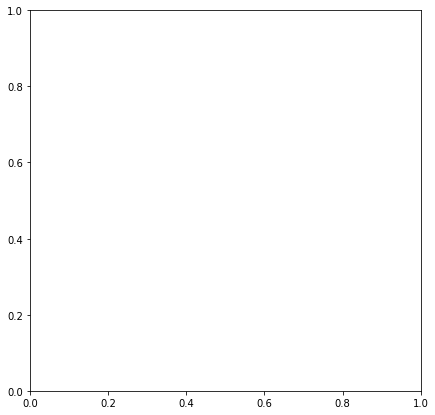

In [2]:

import warnings
warnings.filterwarnings('ignore',category=FutureWarning)
import tensorflow as tf
#import tensorflow.contrib.layers as layers
import tensorflow as tf
#from tensorflow import keras
#from tensorflow.keras import layers
#from keras.utils import to_categorical
#from keras.models import Sequential
#from keras.layers import Dense, Dropout, Embedding, LSTM, GlobalMaxPooling1D, SpatialDropout1D
from tensorflow.keras.utils import to_categorical

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
import torch.optim as optim

import gym
from stable_baselines import DQN,PPO2
from stable_baselines import results_plotter
from stable_baselines.bench import Monitor
from stable_baselines.results_plotter import load_results, ts2xy
from stable_baselines.common.noise import AdaptiveParamNoiseSpec
from stable_baselines.common.callbacks import BaseCallback
from stable_baselines.deepq.policies import MlpPolicy
from stable_baselines.common.policies import FeedForwardPolicy, register_policy,LstmPolicy
from stable_baselines.common.tf_layers import conv, linear, conv_to_fc, lstm
#from stable_baselines.common import get_vec_normalize_env
from stable_baselines.common.env_checker import check_env
from stable_baselines.common.vec_env import DummyVecEnv
#import balance_bot

import socket
import numpy as np
from time import sleep
import UR5_RL

#env= gym.make("UR5-RL-env", render=True)
#HOST_SnS = '192.168.0.103'
HOST_SnS = '128.138.224.89'
PORT_SnS= 65490

class GRUNet(nn.Module):
        def __init__(self, input_dim, hidden_dim, output_dim, n_layers, drop_prob=0.2):
            super(GRUNet, self).__init__()
            self.hidden_dim = hidden_dim
            self.n_layers = n_layers

            self.gru = nn.GRU(input_dim, hidden_dim, n_layers, batch_first=True, dropout=drop_prob)
            self.fc = nn.Linear(hidden_dim, output_dim)
            self.relu = nn.ReLU()

        def forward(self, x, h):
            out, h = self.gru(x, h)
            out = self.fc(self.relu(out[:,-1]))
            return out, h

        def init_hidden(self, batch_size):
            weight = next(self.parameters()).data
            hidden = weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device)
            return hidden

device = torch.device("cpu")

#try:

# Create a TCP/IP socket
sock_SnS = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
#sock_SnS.setblocking(False)
# Connect the socket to the port where the server is listening
server_address_SnS = (HOST_SnS, PORT_SnS)
print('connecting to {} port {}'.format(*server_address_SnS))
sock_SnS.connect(server_address_SnS)


StepsPerEpisode=30 #was 10
TotalEpisodes=380  #was 80
env= gym.make("ur5-rl-v0",StepsPerEpisode=StepsPerEpisode,TotalEpisodes=TotalEpisodes,
                 continuousactionspace=False,actualbutton=True)


env = DummyVecEnv([lambda: env])  #no clue what this line does

#model = DQN.load("UR5-RL_savedpolicy-10-4-2021")  #seems to only go down (action 4). 
#model = DQN.load("UR5-RL_savedpolicy-10-6-2021")  #seems to only go to the side (action 1).
#model = DQN.load("UR5-RL_DQN_savedpolicy_10_14_2021")  #seems to only go down (action 4). 
model = DQN.load("UR5-RL_DQN_savedpolicy_cylinder_withbutton_train_noposeobs_10_21_2021")  #seems to only go down (action 4).




#model = DQN(MlpPolicy, env, learning_rate=0.1,exploration_final_eps=0.02, exploration_initial_eps=1.0,  verbose=1)



#env=model.get_env()
#obs = env.reset()
done = [False for _ in range(1)] #env.num_envs
state=None

while True:
    obs = env.reset()
    #env._seed()
    for i in range(500000):
        action, _states = model.predict(obs,state=state,mask=done)
        #actionlist.append(action)
        obs, rewards, dones, info = env.step(action)
        print(obs)
    #print(rewards)
        
        
        
"""

while True:
    obs = env.reset()
    env._seed()
    actionlist=[]
    #print("reset")
    for i in range(80):
        action, _states = model.predict(obs)
        actionlist.append(action)
        obs, rewards, dones, info = env.step(action)
    print(rewards)       
"""       
        
        
#print("actionlist",actionlist)
#env.render()

[-1.5522386]
